<a href="https://colab.research.google.com/github/ayman-tech/enso-rl/blob/master/enso-rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3 cftime XRO shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


In [2]:
import os
!wget -c -P data/ https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc

# for latest package, uncomment below
# if not os.path.exists('XRO'):
#     os.makedirs('XRO')
# !wget -c -P XRO/ https://raw.githubusercontent.com/senclimate/XRO/refs/heads/main/XRO/core.py
# !wget -c -P XRO/ https://raw.githubusercontent.com/senclimate/XRO/refs/heads/main/XRO/stats.py
# !wget -c -P XRO/ https://raw.githubusercontent.com/senclimate/XRO/refs/heads/main/XRO/visual.py

--2026-01-20 05:23:43--  https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/senclimate/XRO/main/data/XRO_indices_oras5.nc [following]
--2026-01-20 05:23:44--  https://raw.githubusercontent.com/senclimate/XRO/main/data/XRO_indices_oras5.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64666 (63K) [application/octet-stream]
Saving to: ‘data/XRO_indices_oras5.nc’

XRO_indices_oras5.n 100%[===================>]  63.15K  --.-KB/s    in 0.04s   

2026-01-20 05:23:44 (1.41 MB/s) - ‘data/XRO_indices_oras5.nc’ saved [64666/64666]



In [3]:
# 1. Imports and Setup
import sys
import os
import warnings

import numpy as np
import pandas as pd
import xarray as xr
import cftime
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from pprint import pprint

print(f"cftime version: {cftime.__version__}")

cftime version: 1.6.5


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 1. Getting XRO Model Ready

In [4]:
from XRO.core import XRO

In [5]:
import warnings
# XRO package functions give many deprecated warnings & clutter output, disabling them
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

In [6]:
# Loading observational data (SST, etc.) from https://github.com/senclimate/XRO/blob/main/data/XRO_indices_oras5.nc
obs_ds = xr.open_dataset('data/XRO_indices_oras5.nc')
train_ds = obs_ds.sel(time=slice('1979-01', '2022-12'))
train_ds

<xarray.Dataset> Size: 27kB
Dimensions:  (time: 528)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2022-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...
    NPMM     (time) float32 2kB ...
    SPMM     (time) float32 2kB ...
    IOB      (time) float32 2kB ...
    IOD      (time) float32 2kB ...
    SIOD     (time) float32 2kB ...
    TNA      (time) float32 2kB ...
    ATL3     (time) float32 2kB ...
    SASD     (time) float32 2kB ...

In [7]:
# Variable Names
var_names = list(train_ds.data_vars)

# Set Bounds
bounds = {}
for var in var_names:
    bounds[var] = float(train_ds[var].data.min()),float(train_ds[var].data.max())
bounds

{'Nino34': (-2.5239033699035645, 2.760493278503418),
 'WWV': (-26.161357879638672, 14.945099830627441),
 'NPMM': (-1.0359957218170166, 1.346160888671875),
 'SPMM': (-1.344103217124939, 1.246484398841858),
 'IOB': (-0.582121729850769, 0.8382447361946106),
 'IOD': (-1.3184950351715088, 2.2545392513275146),
 'SIOD': (-1.2861250638961792, 1.2243201732635498),
 'TNA': (-1.1494367122650146, 1.2045494318008423),
 'ATL3': (-1.2200918197631836, 1.3619381189346313),
 'SASD': (-1.4807032346725464, 1.7623258829116821)}

In [8]:
# Initialize model as per https://github.com/senclimate/XRO/blob/main/notebooks/XRO_Cookbook.ipynb
# XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus maskb=['IOD'], maskNT=['T2', 'TH']
model = XRO()
fitted_params = model.fit_matrix(
    train_ds,
    maskb=['IOD'],
    maskNT=['T2', 'TH']
)

### EXTRACT PARAMETERS FROM FITTED MODEL

In [9]:
# Prepare parameters for the RL environment

# Noise Covariance
residuals = fitted_params['Y'] - fitted_params['Yfit']
noise_cov = np.cov(residuals.values, rowvar=True)

# Create the params dictionary
params = {
    'model': model,          # The fitted XRO model object
    'fit_ds': fitted_params, # The fitted parameters dataset
    'noise_cov': noise_cov,  # Covariance matrix
    'var_names': var_names,  # List of variable names
    'dt': 1.0 / 12.0         # Time step
}

print("Parameters extracted successfully.")
print(f"Model: {type(params['model'])}")
print(f"Fitted Params included: {'fit_ds' in params}")

Parameters extracted successfully.
Model: <class 'XRO.core.XRO'>
Fitted Params included: True


In [10]:
var_names

['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']

In [11]:
noise_cov.shape

(10, 10)

In [12]:
fitted_params

<xarray.Dataset> Size: 182kB
Dimensions:         (ranky: 10, rankx: 10, cycle: 12, ac_rank: 3, cossin: 5,
                     time: 528, nro_form: 5)
Coordinates:
  * ranky           (ranky) int32 40B 1 2 3 4 5 6 7 8 9 10
  * rankx           (rankx) int32 40B 1 2 3 4 5 6 7 8 9 10
  * cycle           (cycle) float64 96B 0.04167 0.125 0.2083 ... 0.875 0.9583
  * ac_rank         (ac_rank) int32 12B 0 1 2
  * cossin          (cossin) int32 20B 0 1 2 3 4
  * time            (time) float64 4kB 0.04167 0.125 0.2083 ... 43.88 43.96
  * nro_form        (nro_form) <U3 60B 'T2' 'TH' 'T3' 'T2H' 'TH2'
Data variables: (12/31)
    Lac             (ranky, rankx, cycle) float64 10kB -2.226 -2.143 ... -1.959
    Lcomp           (ranky, rankx, cycle, ac_rank) float64 29kB -0.7937 ... 0...
    Lcoef           (ranky, rankx, cossin) float64 4kB -0.7937 ... -0.2527
    X               (rankx, time) float64 42kB -0.1423 0.02629 ... 0.2558 0.9523
    Y               (ranky, time) float32 21kB 2.023 -1.307 ... 8.357 8.357
    Yfit            (ranky, time) float64 42kB 0.2597 -0.1269 ... 3.069 1.128
    ...              ...
    NROT_Lcoef      (nro_form, cossin) float64 200B 0.07285 -0.175 ... 0.0 0.0
    NROT_Lcomp      (nro_form, cycle, ac_rank) float64 1kB 0.07285 ... 0.0
    NROH_Lac        (nro_form, cycle) float64 480B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NROH_Lcoef      (nro_form, cossin) float64 200B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NROH_Lcomp      (nro_form, cycle, ac_rank) float64 1kB 0.0 0.0 ... 0.0 0.0
    var_names       (ranky) <U6 240B 'Nino34' 'WWV' 'NPMM' ... 'ATL3' 'SASD'

# 2. PHYSICS FUNCTION (With Annual Cycle)

Prepare the xro_step fn


* First prepare the data into xarray format, because model.simulate needs data in XArray format
* Do simulate for 1 yr(minimum) and extract nxt months state and convert back to array from XArray format.
* Now add the nextState with control_Action = `(action \* Gain_Multiplier) / 12` we assume the action for year
* Also do clip state to prevent large change, and set to 0 if simulate returns NaN values.

**To-Do**
* action is currently applied to enso index only, we can apply for other indexes also
* XRO is an ensemble model so need to check the values. (for now im just taking val of first ensemble members value)

**Why roll the model**

- The XRO.simulate function is "rigid": it always starts simulating from the first index (0) of the parameter dataset it receives.
If we are actually in March (index 2), we need the model to behave like it's March, not January.
- .roll(cycle=-current_month_idx): This rotates the data list backwards. It moves the parameters at index 2 (March) to index 0.
- Result: When the simulator reads the first item, it now finds the March parameters, ensuring the physics match the calendar.

In [13]:
debug = True
action_scale = [1.8, 0.4, 0.3, 0.3, 0.7, 0.4, 0.35, 0.6, 0.4]
print("Action  Scale")
for i in range(len(action_scale)):
    print(f"{var_names[i+1]:<6} : {action_scale[i]}")

Action  Scale
WWV    : 1.8
NPMM   : 0.4
SPMM   : 0.3
IOB    : 0.3
IOD    : 0.7
SIOD   : 0.4
TNA    : 0.35
ATL3   : 0.6
SASD   : 0.4


In [14]:
def xro_step(state, params, action, rng, step_idx):
    """
    Adds Action (Tuned) to the state and advances the XRO model by
    one month using model.simulate().
    """
    model = params['model']
    current_month_idx = step_idx % 12 # current month index
    # Roll parameters to align with the current calendar month
    fit_ds = params['fit_ds'].roll(
        cycle = -current_month_idx,
        roll_coords = False
    )

    var_names = params['var_names']
    global bounds # Access the global bounds dictionary

    # 1. Apply Control Action
    control_actions = np.zeros_like(state)
    control_actions = action * action_scale
    control_actions = np.insert(control_actions, 0, 0) # add 0 at beginning for nino action = 0

    #  Update State & Safety clip
    updated_state = state + control_actions
    for i, var_name in enumerate(var_names):
        min_val, max_val = bounds[var_name]
        updated_state[i] = np.clip(updated_state[i], min_val, max_val)

    # 2. Prepare Input for XRO.simulate
    # Use scalar values to ensure correct shape (N,) for to_array()
    data_dict = {
        name: float(val)
        for name, val in zip(var_names, updated_state) # var_name : state_var
    }
    input_ds = xr.Dataset(data_dict)


    # 3. Compute Dynamics using model.simulate
    # Use a local seed for reproducibility in this step
    seed = int(rng.integers(0, 1_000_000))
    try:
        prediction_ds = model.simulate(
            fit_ds = fit_ds, # Dataset containing model fit results.
            X0_ds = input_ds, # Initial conditions dataset.
            nyear = 1, # no of simulations : min is 1
            seed = seed
        )

        # 4. Extract the next state (t+1)
        # We take time=0 (first step) and member=0 (default member)
        next_state_ds = prediction_ds.isel(time=0)

        # Handle member dimension if it exists (XRO outputs usually have it)
        if 'member' in next_state_ds.coords or 'member' in next_state_ds.dims:
            next_state_ds = next_state_ds.isel(member=0)

        # FIX: Ensure next_state is always a 1D array of scalars
        next_state = np.array(
            [float(next_state_ds[name]) for name in var_names]
        )

    except Exception as e:
        # Fallback if simulation fails (e.g. instability)
        print(f"Warning: Simulation failed at step {step_idx}. Resetting state. Error: {e}")
        return np.zeros_like(state)

    # 5. Safety Clipping and NaN check
    for i, var_name in enumerate(var_names):
        min_val, max_val = bounds[var_name]
        next_state[i] = np.clip(next_state[i], min_val, max_val)

    # If we still have NaNs (e.g. from the model internals), replace with zeros
    if np.isnan(next_state).any():
        return np.zeros_like(state)

    if debug:
        # print(f'Control Actions : {control_actions}') # DEBUG
        # print(f'State B4 Action : {next_state_natural}') # DEBUG
        # print(f'State Af Action : {next_state}') # DEBUG
        return control_actions, updated_state, next_state

    return next_state

**Why Member dimension is parsed**

XRO simulate's Output contains multiple values of ensemble, currently only first member is used.

In [15]:
def get_data(target_year, target_month):
    """
    Returns the 10 variables of given month and year.
    """
    year_month_data = train_ds.sel(time=f'{target_year}-{target_month:02d}')

    year_month_var_values = []
    for var in var_names:
        year_month_var_values.append(float(year_month_data[var].values.item())) # Using .item() as it's a single value

    return year_month_var_values


In [16]:
from prompt_toolkit.application import current
#-------------------------------------------------
#        IGNORE CELL: CREATED TO TEST xro step fn
#-------------------------------------------------
if debug :
    rng = np.random.default_rng(seed=42) # Random Number Generator

    # 2. Define Initial State (Neutral / Mean State)
    n_vars = len(params['var_names'])
    current_state = get_data(
        target_year = 1979,
        target_month = 1 # January 1979
    )

    # 3. Define Inputs
    action = np.random.normal(loc=0, scale=0.5, size=9) # TUNE SCALE
    step_idx = 0       # January (Month 0)

    # TABLE with DEBUG MODE
    control_actions, updated_state, next_state = xro_step(
        current_state, params, action, rng, step_idx
    )
    action_10 = np.insert(action, 0, 0)
    data = {
        'Variables': var_names,
        'Action*': action_10,
        'Control_Actions': control_actions,
        'Current_State*': current_state,
        'Updated State': updated_state,
        'Next_State': next_state
    }

    # Create a pandas DataFrame from the dictionary
    df_table = pd.DataFrame(data)
    display(df_table)


,Variables,Action*,Control_Actions,Current_State*,Updated State,Next_State
0,Nino34,0.000000,0.000000,-0.142279,-0.142279,-0.292437
1,WWV,0.452083,0.813749,11.066086,11.879835,12.520493
2,NPMM,-0.225517,-0.090207,-0.253452,-0.343659,-0.439449
3,SPMM,-0.412389,-0.123717,0.506946,0.383229,0.373121
4,IOB,0.817370,0.245211,0.187517,0.432729,0.331181
5,IOD,0.288128,0.201690,0.431726,0.633416,0.348054
6,SIOD,0.534524,0.213810,0.311924,0.525733,0.310576
7,TNA,0.788246,0.275886,0.233285,0.509171,0.506336
8,ATL3,0.026562,0.015937,-0.187185,-0.171248,-0.225163
9,SASD,0.631783,0.252713,0.251324,0.504037,0.455599


In [17]:
debug = False

# 3. GYM ENVIRONMENT
Prepare the gym environment of XRO multi year env

In [18]:
class XROMultiYearEnv(gym.Env):
    def __init__(self, params, episode_length=72):
        super(XROMultiYearEnv, self).__init__()
        self.params = params
        self.n_modes = len(params['var_names'])
        self.episode_length = episode_length
        self.current_step = 0
        self.rng = np.random.default_rng()

        self.action_space = spaces.Box(
            low = -1.0,
            high = 1.0,
            shape = (9,),
            dtype = np.float32
        )
        # Obs: State + Month (linear 0-1)
        self.observation_space = spaces.Box(
            low = -np.inf,
            high = np.inf,
            shape = (self.n_modes + 1,),
            dtype = np.float32
        )
        self.enso_history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.rng = np.random.default_rng(seed)

        # Start with small random state
        # self.state = self.rng.standard_normal(self.n_modes) * 0.1
        self.state = get_data(1979, 1)
        self.current_step = 0
        self.enso_history = [self.state[0]]
        return self._get_obs(), {}

    def _get_obs(self):
        """
        Observation Space = [State, month]
        """
        # Normalize month to 0-1 for the agent
        month_feature = (self.current_step % 12) / 12.0
        return np.concatenate([self.state, [month_feature]])

    def step(self, action):
        """
        Step the model with action and add reward
        """
        # Pass 'self.current_step' to xro_step so it knows the month
        self.state = xro_step(self.state, self.params, action, self.rng, self.current_step)
        self.enso_history.append(self.state[0])

        self.current_step += 1
        terminated = (self.current_step >= self.episode_length)
        # Initialize rewards
        enso_reward = 0.0
        action_penalty = 0.0
        multi_year_event_reward = 0.0

        # 1. Continuous Reward for ENSO Index Values
        enso_index = self.state[0] # Nino34 index
        threshold = 1.0

        if enso_index > threshold:
            enso_reward = 0.1 # Reward for El Niño strength
        elif enso_index < -threshold:
            enso_reward = 0.1 # Reward for La Niña strength
        # Else, enso_reward remains 0 for values within threshold

        # 2. Penalty for large control actions
        action_penalty = -0.01 * np.sum(np.abs(action)**2) # Penalize squared sum of actions

        # 3. Existing Multi-year event reward (only at termination)
        if terminated:
            if self._check_multi_year_event(self.enso_history):
                multi_year_event_reward = 10.0

        # Combine all reward components
        reward = enso_reward + action_penalty + multi_year_event_reward

        # Print individual reward components for debugging
        # if self.current_step % 12 == 0 or terminated: # Print every 12 steps or at termination
        #     print(f"Step {self.current_step}: ENSO Reward={enso_reward:.3f}, Action Penalty={action_penalty:.3f}, Multi-Year Reward={multi_year_event_reward:.3f}, Total Reward={reward:.3f}")

        return self._get_obs(), reward, terminated, False, {}

    def _check_multi_year_event(self, history):
        """
        Check if for at least 2 years, the enso index is beyond threshold
        """
        history = np.array(history)
        threshold = 1.0
        min_duration = 24 # at least 2 years for multi-year event

        # El Nino Check
        is_nino = (history >= threshold).astype(int) # check all history > thres
        if self._max_run_length(is_nino) >= min_duration:
            return True

        # La Nina Check
        is_nina = (history <= -threshold).astype(int)
        if self._max_run_length(is_nina) >= min_duration:
            return True

        return False

    def _max_run_length(self, binary_sequence):
        """
        calculates longest duration of consecutive 1s in bin sequence
        """
        padded = np.concatenate(([0], binary_sequence, [0]))
        changes = np.diff(padded)
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        if len(starts) == 0:
            return 0
        return (ends - starts).max()

# 4. RUN TRAINING
PPO Model with MLP_Policy : https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

In [20]:
env = XROMultiYearEnv(params)
model_ppo = PPO("MlpPolicy", env, verbose=1)

# 2048 TimeSteps for a quick check.
model_ppo.learn(total_timesteps= 2_048*10) # TUNE

print("Training Complete ")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72       |
|    ep_rew_mean     | 0.12     |
| time/              |          |
|    fps             | 30       |
|    iterations      | 1        |
|    time_elapsed    | 66       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | 0.73        |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 2           |
|    time_elapsed         | 134         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010123536 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss   

Analysis of this output is here :

https://chatgpt.com/s/t_6958ad54cf348191add64a61e72665cf

## 6. Evaluation and Comparison

We compare the frequency of multi-year events between:
1. **No Control**: Action = 0
2. **RL Agent**: Action = Policy


In [21]:
def evaluate_agent(env, agent=None, num_episodes=50):
    success_count = 0

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            if agent:
                action, _ = agent.predict(obs)
            else:
                action = np.zeros(9) # No control

            obs, reward, done, _, _ = env.step(action)

            # If reward > 1 => success
            if done and reward > 1.0:
                success_count += 1

    return success_count / num_episodes

# Evaluate
freq_no_control = evaluate_agent(env, agent=None, num_episodes=50)
freq_rl_agent = evaluate_agent(env, agent=model_ppo, num_episodes=50)

print(f"Multi-Year Event Probability (No Control): {freq_no_control:.2%}")
print(f"Multi-Year Event Probability (RL Agent):   {freq_rl_agent:.2%}")

Multi-Year Event Probability (No Control): 2.00%
Multi-Year Event Probability (RL Agent):   90.00%


### Plot
Simulates single episode using the trained Reinforcement Learning agent (model_ppo) and then visualizes the outcome. Record the evolution of the ENSO index (the first component of the state) and the corresponding control actions taken by the agent over the course of the episode.

2 plots are generated:
1. **Sample Controlled ENSO Trajectory**: This plot of how the ENSO index changes month by month under the influence of the RL agent's actions. It includes horizontal lines indicating the typical thresholds for El Niño (0.8) and La Niña (-0.8) events, allowing you to see how the agent's control affects these phenomena.
2. **Control Actions**: This plot displays the sequence of control actions applied by the agent throughout the simulated episode.

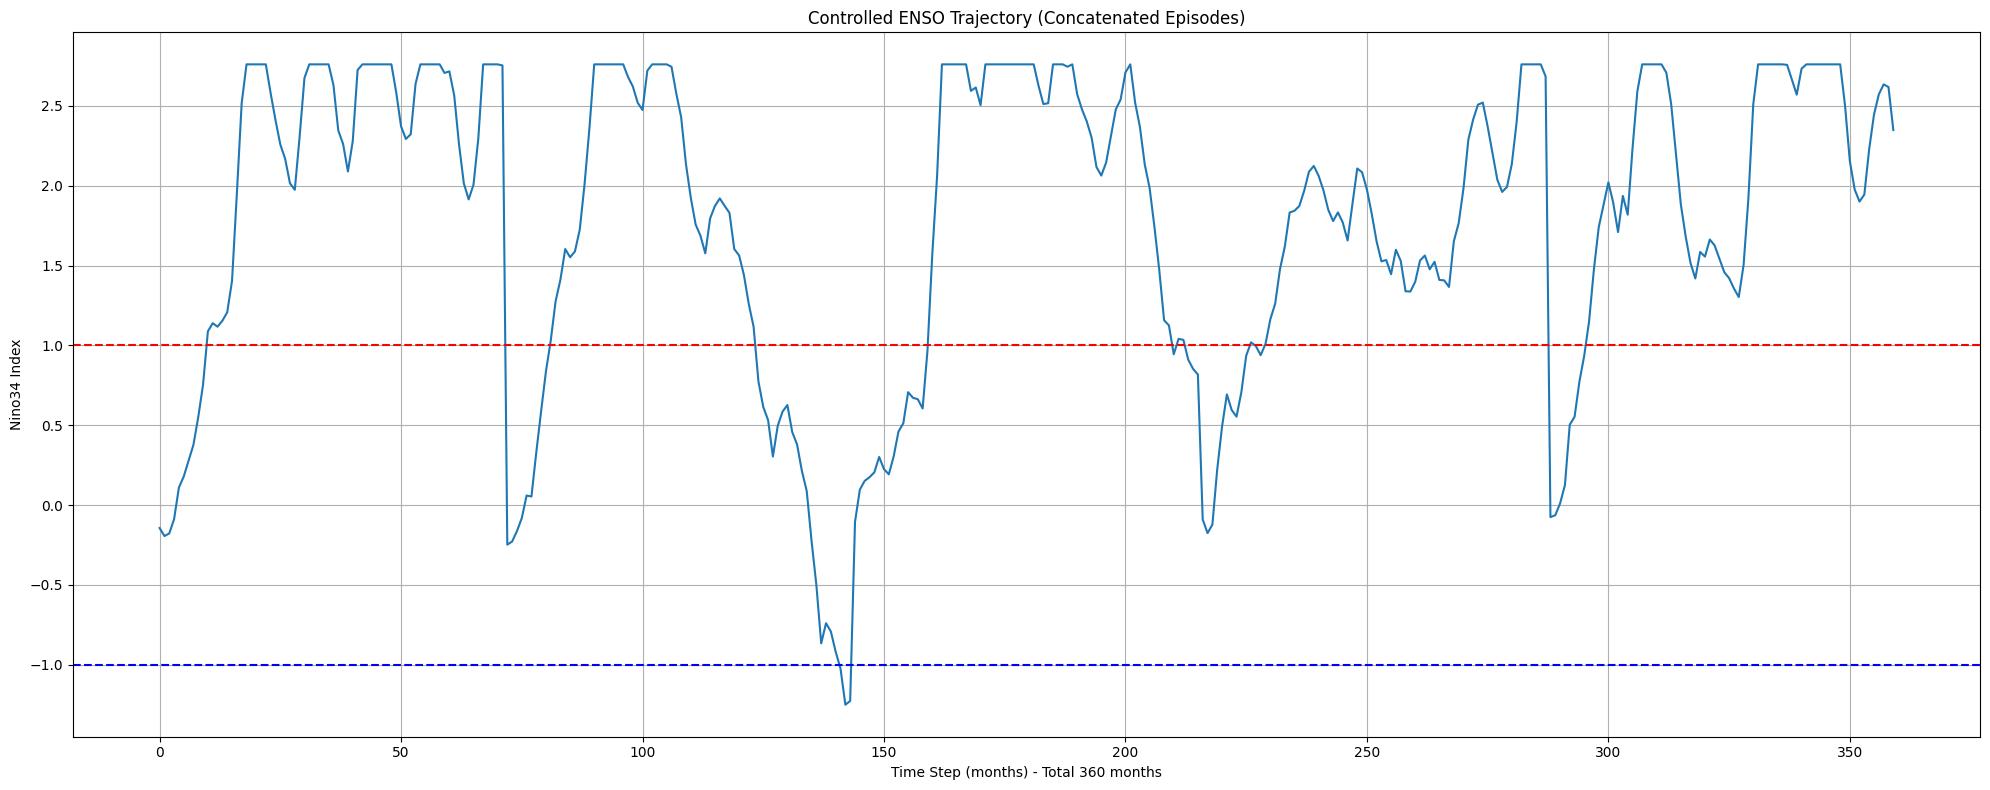

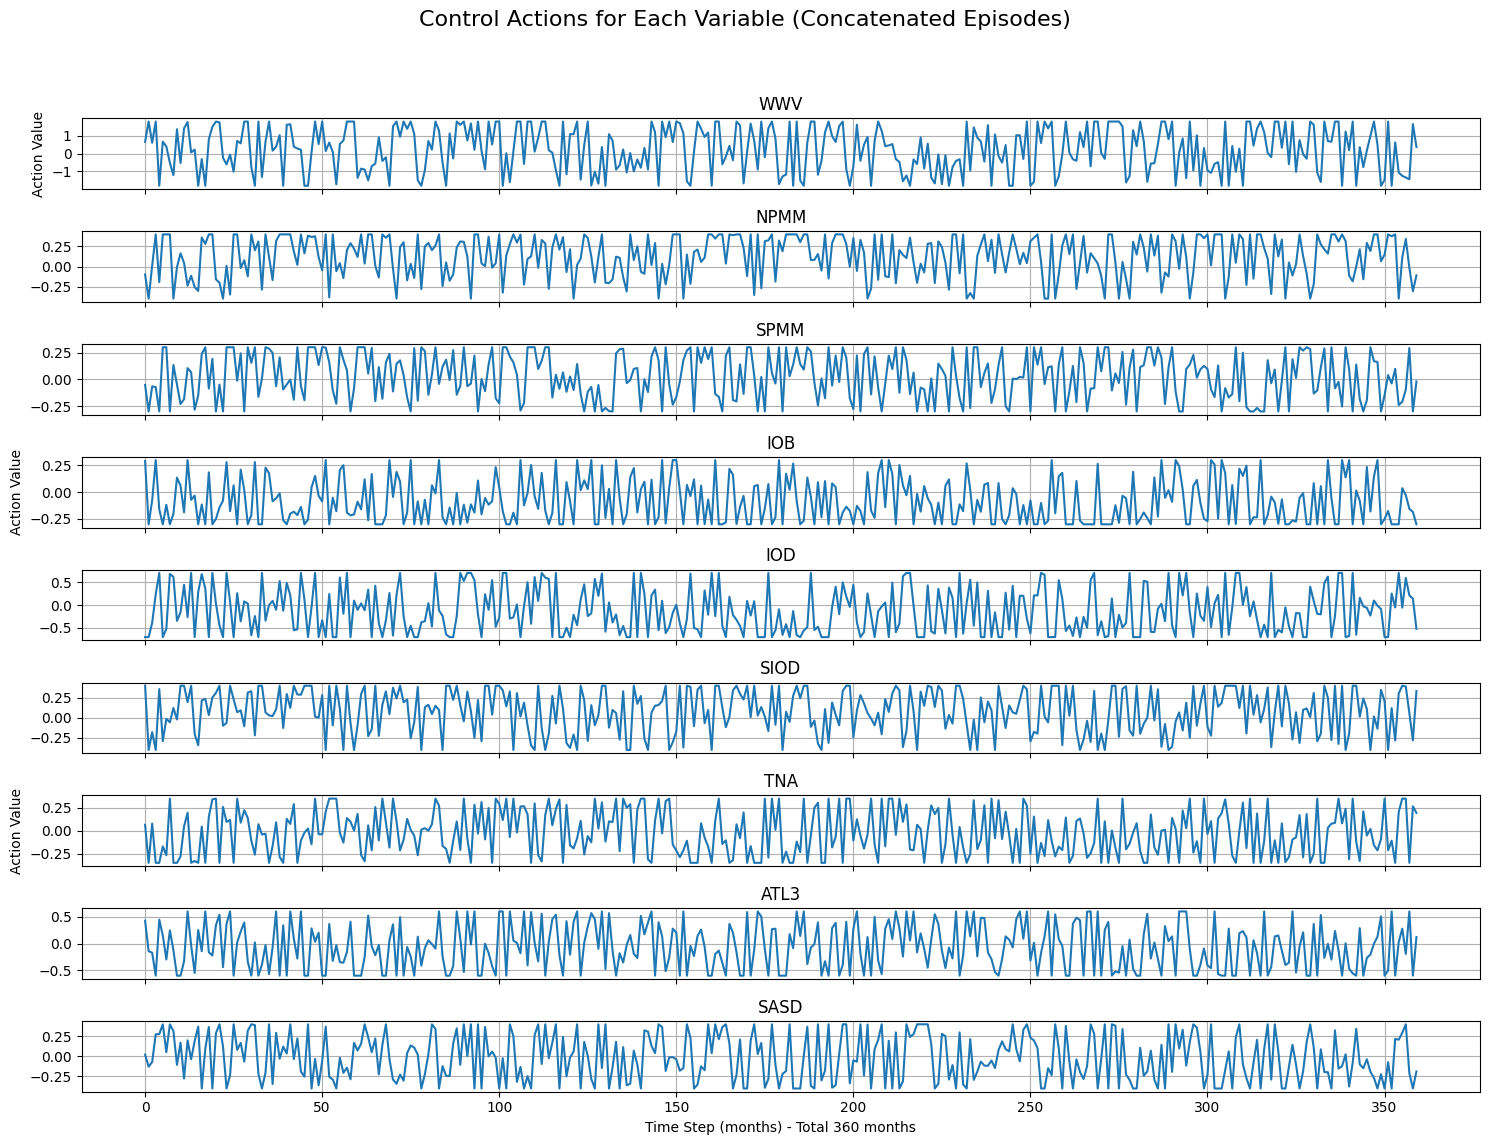

In [22]:
# Plotting action trajectory
threshold = 1.0

num_episodes_to_simulate = 5 # TUNE

enso_traj = [] # Renamed for clarity, original was enso_trajs
actions_data_list = [] # Renamed for clarity, original was actions_data

for episode_num in range(num_episodes_to_simulate):
    obs, _ = env.reset()
    done = False
    while not done: # run for 1 episode (6 yrs)
        action, _ = model_ppo.predict(obs)
        # Apply action_scale for plotting the actual control applied
        scaled_action = action * action_scale
        obs, reward, done, _, _ = env.step(action)
        enso_traj.append(obs[0]) # State[0] is ENSO index
        actions_data_list.append(scaled_action) # Append the scaled action vector

actions_data = np.vstack(actions_data_list) # Convert 2d list to a single 2D np array

# --- Plotting Concatenated Episodes ---

# Main figure for ENSO trajectory (concatenated episodes)
plt.figure(figsize=(20, 8))
plt.plot(enso_traj)
plt.axhline(threshold, color='r', linestyle='--', label='El Nino Thr')
plt.axhline(-threshold, color='b', linestyle='--', label='La Nina Thr')
plt.title("Controlled ENSO Trajectory (Concatenated Episodes)")
plt.xlabel(f"Time Step (months) - Total {len(enso_traj)} months")
plt.ylabel("Nino34 Index")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a figure for all action variables in separate subplots (concatenated episodes)
num_actions = actions_data.shape[1] # Get number of actions from the concatenated array
fig2, axes = plt.subplots(nrows=9, ncols=1, figsize=(15, 12), sharex=True)
fig2.suptitle("Control Actions for Each Variable (Concatenated Episodes)", fontsize=16)

axes = axes.flatten() # Flatten the array of axes for easy iteration

for i in range(num_actions):
    axes[i].plot(actions_data[:, i]) # Plot from the concatenated array
    axes[i].set_title(f'{var_names[i+1]}') # Using var_names for titles
    axes[i].grid(True)
    if i == num_actions-1: # Add x-label only for bottom row plots (assuming 9 plots, bottom row starts at index 6)
        axes[i].set_xlabel(f"Time Step (months) - Total {len(enso_traj)} months")
    if i % 3 == 0: # Add y-label only for left-most column plots
        axes[i].set_ylabel("Action Value")

# Hide any unused subplots (not strictly necessary if nrows=num_actions and ncols=1, but good practice)
for j in range(num_actions, len(axes)):
    if j < len(axes): # Ensure index is within bounds before deleting
        fig2.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

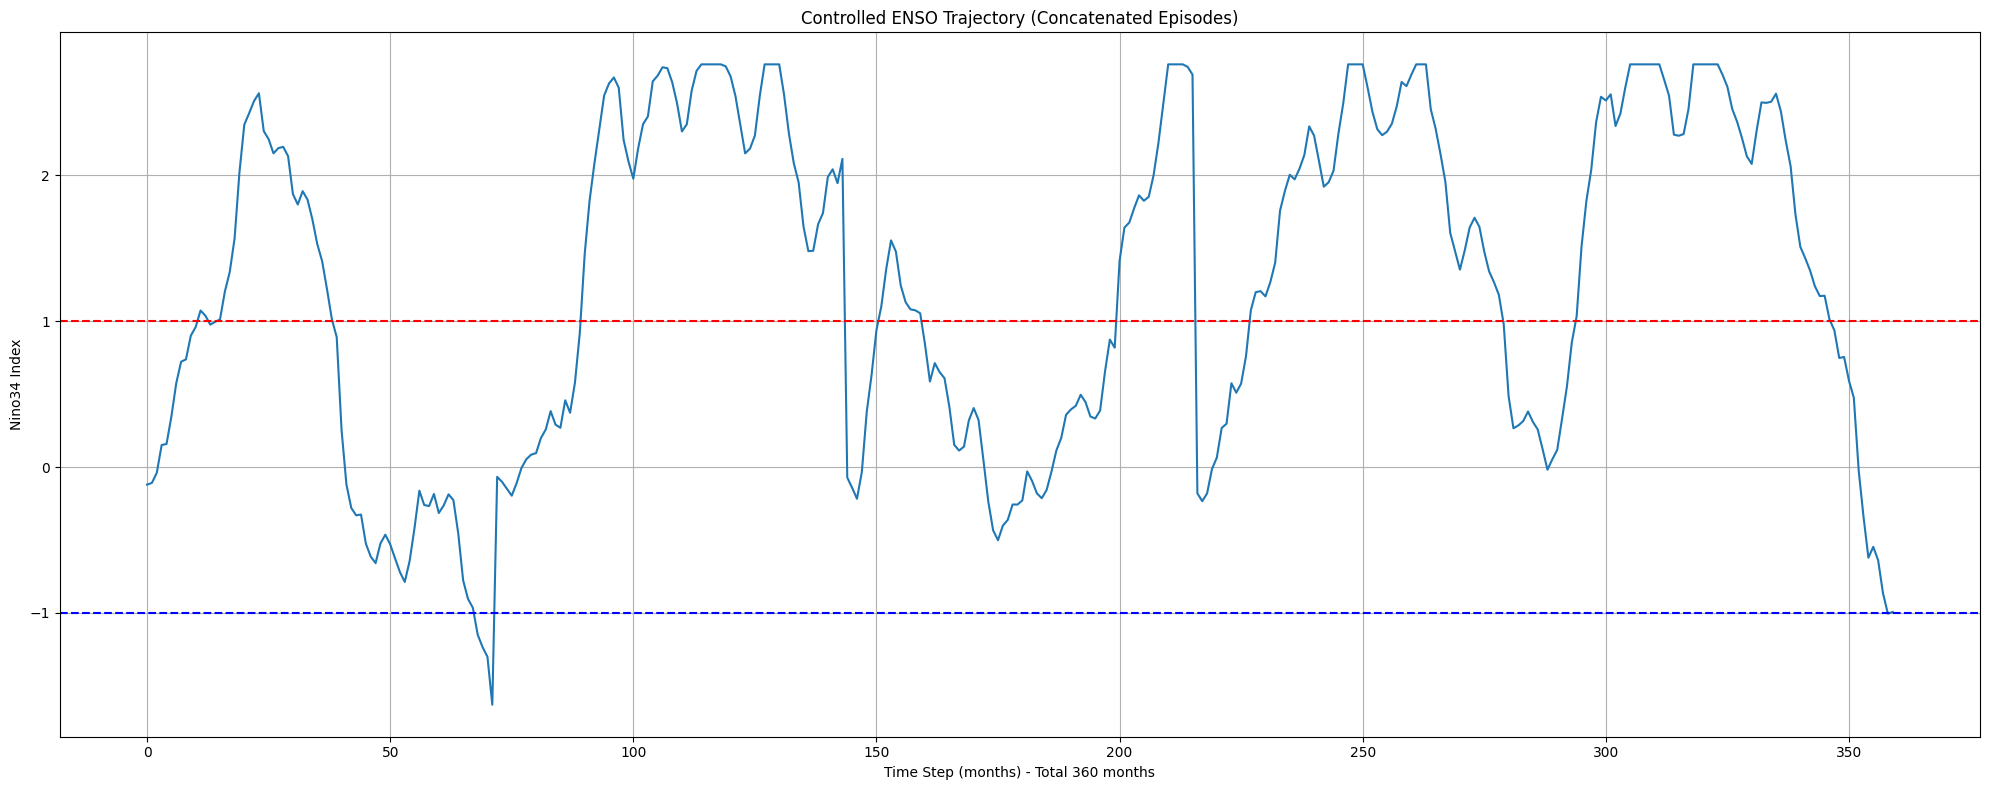

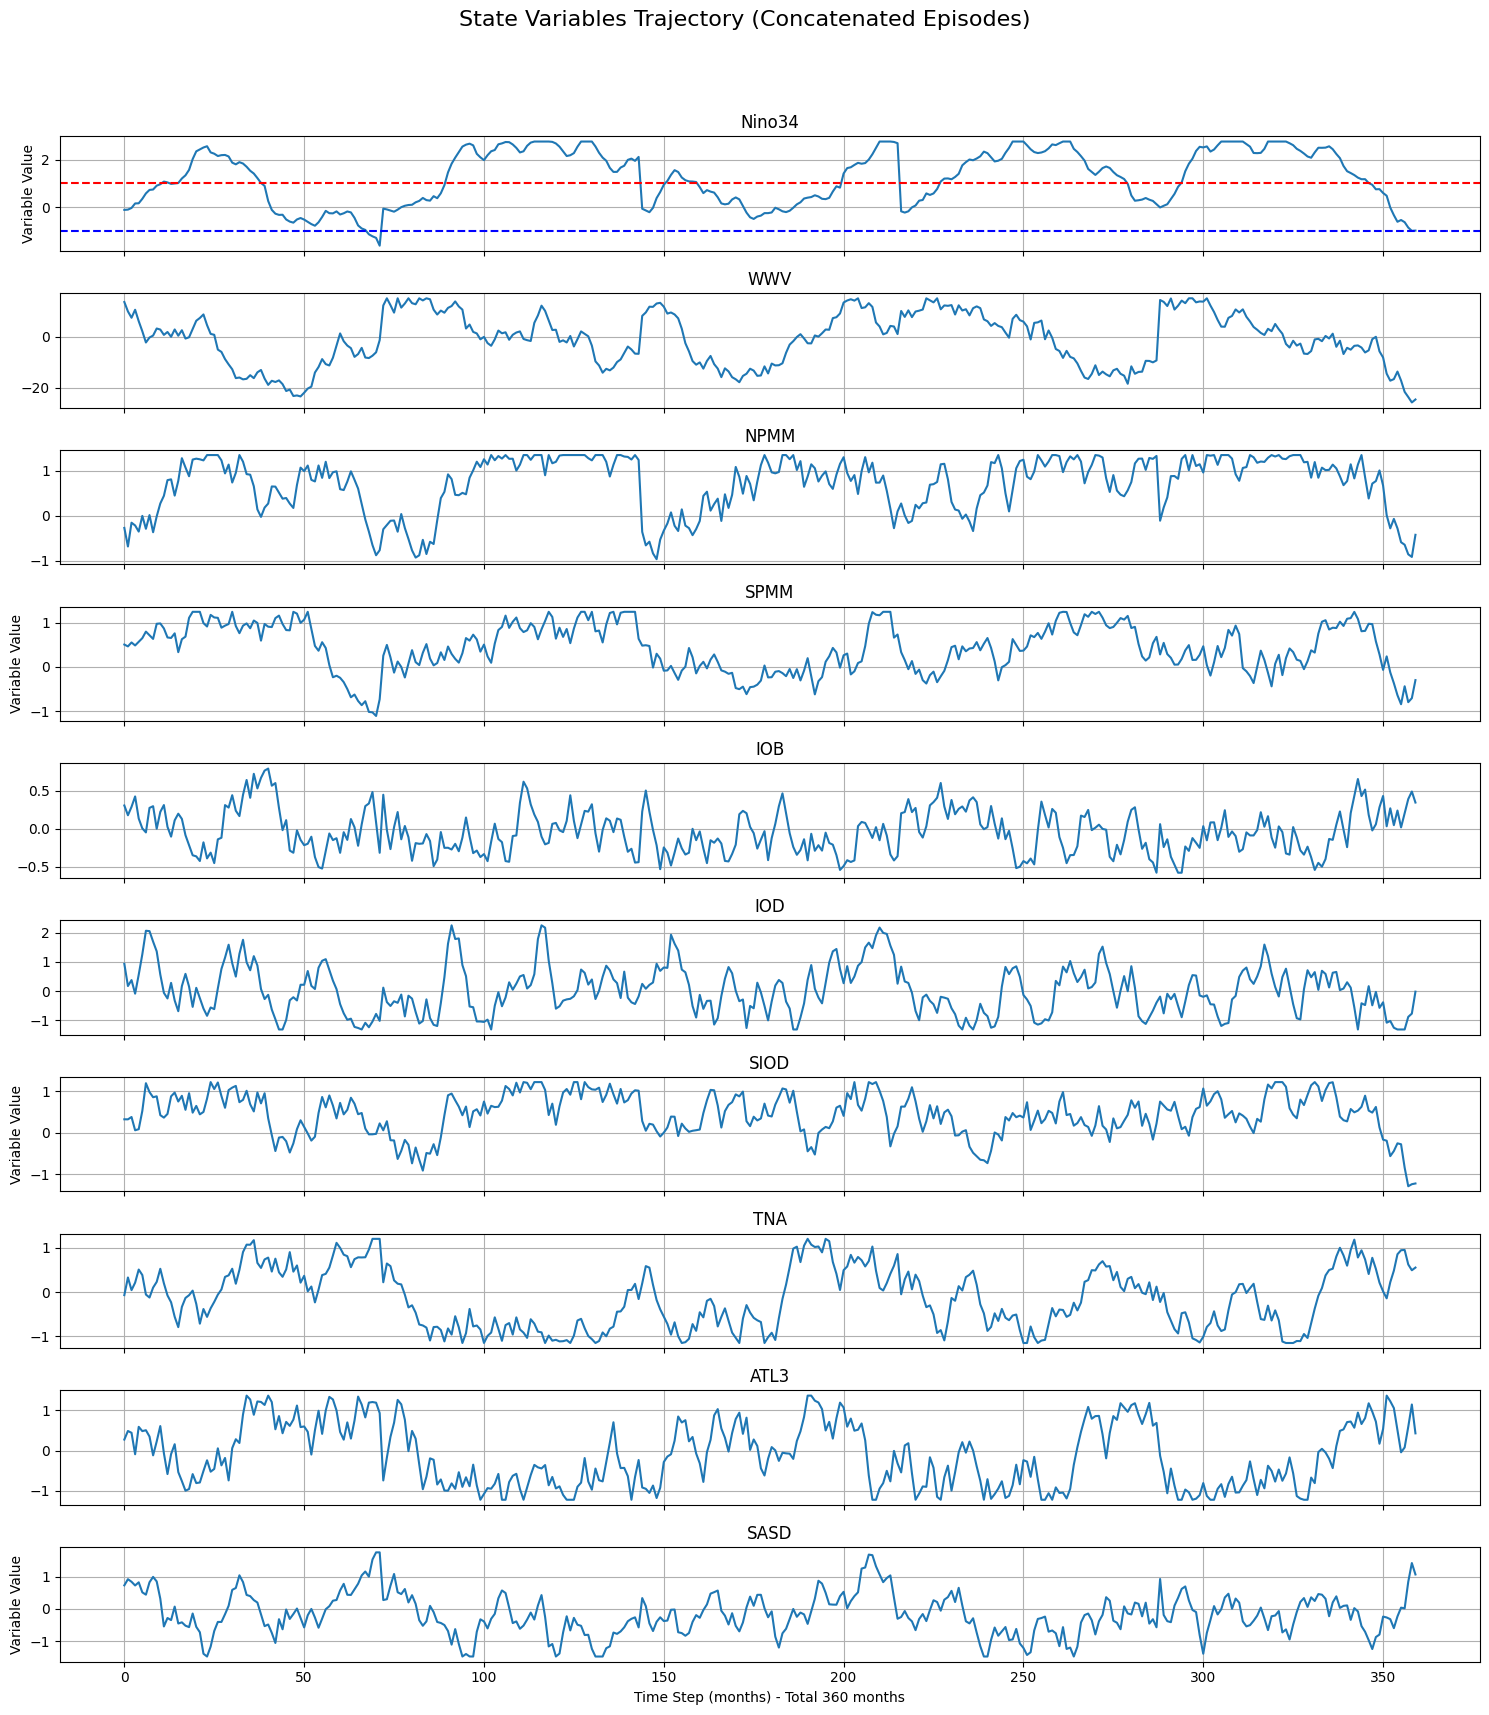

In [23]:
# Plotting variables trajectory
threshold = 1.0

num_episodes_to_simulate = 5 # TUNE

enso_traj = [] # Renamed for clarity, original was enso_trajs
variables_data_list = [] # List to store all state variables

for episode_num in range(num_episodes_to_simulate):
    obs, _ = env.reset()
    done = False
    while not done: # run for 1 episode (6 yrs)
        action, _ = model_ppo.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        enso_traj.append(obs[0]) # State[0] is ENSO index
        variables_data_list.append(obs[:-1]) # Append all state variables (excluding month feature)

variables_data = np.vstack(variables_data_list) # Convert 2d list to a single 2D np array

# --- Plotting Concatenated Episodes ---

# Main figure for ENSO trajectory (concatenated episodes)
plt.figure(figsize=(20, 8))
plt.plot(enso_traj)
plt.axhline(threshold, color='r', linestyle='--', label='El Nino Thr')
plt.axhline(-threshold, color='b', linestyle='--', label='La Nina Thr')
plt.title("Controlled ENSO Trajectory (Concatenated Episodes)")
plt.xlabel(f"Time Step (months) - Total {len(enso_traj)} months")
plt.ylabel("Nino34 Index")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a figure for all state variables in separate subplots (concatenated episodes)
num_variables = variables_data.shape[1] # Get number of variables from the concatenated array
fig2, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(15, 18), sharex=True) # Increased figsize for 10 plots
fig2.suptitle("State Variables Trajectory (Concatenated Episodes)", fontsize=16)

axes = axes.flatten() # Flatten the array of axes for easy iteration

for i in range(num_variables):
    axes[i].plot(variables_data[:, i]) # Plot from the concatenated array
    axes[i].set_title(f'{var_names[i]}') # Using var_names for titles (no +1 needed as it's the variables themselves)
    axes[i].grid(True)
    if(i==0):
        axes[i].axhline(threshold, color='r', linestyle='--', label='El Nino Thr')
        axes[i].axhline(-threshold, color='b', linestyle='--', label='La Nina Thr')
    if i == num_variables -1: # Add x-label only for the last plot
        axes[i].set_xlabel(f"Time Step (months) - Total {len(enso_traj)} months")
    if i % 3 == 0 or i == 0: # Add y-label for every third plot or the first one
        axes[i].set_ylabel("Variable Value")

# Hide any unused subplots (not strictly necessary if nrows=num_variables and ncols=1)
for j in range(num_variables, len(axes)):
    if j < len(axes):
        fig2.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [24]:
from IPython.display import display
import pandas as pd
import numpy as np

# 1. Prepare Data
raw_data = np.array(enso_traj)

# Calculate 3-month running mean (centered)
# min_periods=2 allows calculation at edges (t=0 uses t, t+1; t=end uses t-1, t)
data = pd.Series(raw_data).rolling(window=3, center=True, min_periods=2).mean().values

# 2. Reshape into (Years x 12 Months)
n_months = 12
n_years = len(data) // n_months

# Truncate data to fit full years
data_full_years = data[:n_years * n_months]
reshaped_data = data_full_years.reshape(n_years, n_months)

# 3. Create DataFrame
months = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
df_enso = pd.DataFrame(reshaped_data, columns=months)
df_enso.index.name = 'Year \\'
# Adjust index to start from 1 (or specific year if known)
df_enso.index = df_enso.index + 1

# 4. Define Styling Function
def color_enso_values(val):
    """
    Colors values > 1 in Red, and < 1 in Blue.
    """
    # color = 'black'
    color = 'white'
    if val > 1.0:
        color = 'red'
    elif val < -1.0:
        # color = 'blue'
        color = 'lightblue'
    return f'color: {color}'

# 5. Apply Style and Format
# We use .map() (pandas >= 2.1.0) or .applymap() for older versions
styler = df_enso.style.format("{:.2f}") # Format to 2 decimal places

try:
    styler = styler.map(color_enso_values)
except AttributeError:
    styler = styler.applymap(color_enso_values)

# Display the styled table explicitly
display(styler)

,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
Year \,,,,,,,,,,,,
1,-0.11,-0.09,0.00,0.09,0.22,0.36,0.55,0.68,0.79,0.87,0.98,1.02
2,1.03,1.00,0.99,1.07,1.18,1.37,1.64,1.98,2.26,2.43,2.50,2.46
3,2.37,2.23,2.19,2.18,2.17,2.07,1.93,1.85,1.84,1.81,1.69,1.55
4,1.39,1.22,1.04,0.72,0.34,-0.05,-0.24,-0.31,-0.39,-0.49,-0.60,-0.60
5,-0.55,-0.51,-0.54,-0.63,-0.71,-0.72,-0.62,-0.41,-0.28,-0.23,-0.24,-0.26
6,-0.25,-0.26,-0.23,-0.29,-0.49,-0.71,-0.88,-1.01,-1.12,-1.23,-1.39,-1.00
7,-0.60,-0.11,-0.15,-0.15,-0.10,-0.02,0.04,0.08,0.13,0.18,0.28,0.31
8,0.31,0.34,0.37,0.47,0.62,0.99,1.40,1.79,2.07,2.31,2.50,2.62
9,2.63,2.50,2.31,2.10,2.09,2.17,2.31,2.47,2.58,2.69,2.72,2.70


---

# End

---
Ignore below codes

In [25]:
# Source code of the simulate method for dimension handling
print(XRO.simulate.__doc__)


        Simulates the time evolution of the system using the fitted model parameters.
    
        Parameters:
            fit_ds (xarray.Dataset): Dataset containing model fit results.
            X0_ds (xarray.Dataset): Initial conditions dataset.
            nyear (int, optional): Number of simulation years. Default is 10.
            nstep (int, optional): Number of integration steps per cycle. Default is 10.
            ncopy (int, optional): Number of ensemble members. Default is 1.
            seed (int or None, optional): Random seed for noise generation. Default is None.
            noise_type (str, optional): Type of noise ('red' or 'white'). Default is 'red'.
            time (array-like, optional): Time coordinates for the output dataset.
            is_xi_stdac (bool, optional): If True, uses the standard deviation of the autocorrelated noise. Default is True.
            xi_B (float or np.ndarray, optional): Scaling factor for noise perturbation. Default is None. 
      

In [26]:
train_ds['Nino34'].head(time=10)

<xarray.DataArray 'Nino34' (time: 10)> Size: 40B
array([-0.142279,  0.026295, -0.082657,  0.064349,  0.037303, -0.149083,
       -0.289337,  0.046268,  0.342448,  0.296233], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 80B 1979-01-01 1979-02-01 ... 1979-10-01
    month    (time) int32 40B ...
Attributes:
    standard_name:       Sea Surface temperature
    long_name:           SST 5°S–5°N, 170°–120°W
    units:               C
    online_operation:    ave(x)
    interval_operation:  1200.0
    interval_write:      2678400.0
    offline_operation:   ave(x)

In [27]:
# Print the first 5 values of the Nino34 variable
print("First 5 values of Nino34:")
display(train_ds['Nino34'].head(time=5))

First 5 values of Nino34:


<xarray.DataArray 'Nino34' (time: 5)> Size: 20B
array([-0.142279,  0.026295, -0.082657,  0.064349,  0.037303], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 40B 1979-01-01 1979-02-01 ... 1979-05-01
    month    (time) int32 20B ...
Attributes:
    standard_name:       Sea Surface temperature
    long_name:           SST 5°S–5°N, 170°–120°W
    units:               C
    online_operation:    ave(x)
    interval_operation:  1200.0
    interval_write:      2678400.0
    offline_operation:   ave(x)

In [28]:
np.random.randn()

0.4824935087890579

In [29]:
import numpy as np

# random from normal (mean(loc) = 0 & SD (scale) = 0.05)
normal_array = np.random.normal(loc=0, scale=0.05, size=10)
print(normal_array)

[ 0.05305264  0.09037489 -0.03029878 -0.01722539  0.06403813  0.01003995
  0.00322485 -0.01133805  0.02301713  0.05021302]


# Task
To perform an Interventional Driver Analysis, I'll create a function `run_simulation_with_intervention` to evaluate the RL agent's performance (total reward and multi-year event probability) with specific control actions optionally disabled. This function will be the core of the analysis, allowing for the quantification of each feature's impact on the overall outcome.

```python
def run_simulation_with_intervention(
    env,
    model=None, # RL policy
    num_episodes=50,
    disabled_action_index=None
):
    """
    Simulates episodes with an optional RL policy and with the ability to disable a specific
    control action (set it to zero).

    Args:
        env (gym.Env): The simulation environment.
        model (stable_baselines3.common.base_class.BaseAlgorithm, optional): The trained
            RL model. If None, no control actions are applied (baseline for 'no control').
        num_episodes (int): The number of episodes to simulate.
        disabled_action_index (int, optional): The index of the action to disable (set to 0).
            If None, all actions from the model (or zero actions if model is None) are used.

    Returns:
        tuple: A tuple containing:
            - total_reward (float): The sum of rewards across all episodes.
            - multi_year_event_probability (float): The probability of a multi-year ENSO event.
    """
    total_rewards = []
    multi_year_event_success_count = 0

    # Ensure debug mode is off for consistent simulation
    global debug
    original_debug_state = debug
    debug = False

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        episode_enso_history = []

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
            else:
                # No control: all actions are zero
                action = np.zeros(env.action_space.shape[0])

            # Apply intervention: set a specific action to zero if requested
            if disabled_action_index is not None:
                action[disabled_action_index] = 0.0

            obs, reward, done, _, _ = env.step(action)
            episode_reward += reward
            episode_enso_history.append(obs[0]) # Assuming ENSO index is the first observation

            if done:
                # Check for multi-year event only at the end of the episode
                if env._check_multi_year_event(episode_enso_history):
                    multi_year_event_success_count += 1

        total_rewards.append(episode_reward)

    # Restore debug mode to its original state
    debug = original_debug_state

    avg_total_reward = np.mean(total_rewards)
    multi_year_event_probability = multi_year_event_success_count / num_episodes

    return avg_total_reward, multi_year_event_probability

print("`run_simulation_with_intervention` function created successfully.")
```

## Prepare Flexible Evaluation Function

### Subtask:
Create a function `run_simulation_with_intervention` that can simulate a specified number of episodes, either with the full RL policy or with the control action for a specific feature disabled. This function should return the total reward accumulated over episodes and the multi-year event probability.


**Reasoning**:
I need to define the `run_simulation_with_intervention` function as described in the subtask instructions. This function will allow for flexible simulation and evaluation, including scenarios where specific control actions are disabled.



In [30]:
def run_simulation_with_intervention(
    env,
    agent=None,
    num_episodes=50,
    disable_control_for_idx=None,
    debug_output=False
):
    total_reward_sum = 0.0
    success_count = 0
    all_enso_histories = []

    for episode_num in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0.0
        episode_enso_history = [obs[0]] # Store initial ENSO state

        while not done:
            if agent:
                action, _ = agent.predict(obs, deterministic=True)
            else:
                action = np.zeros(env.action_space.shape)

            # Apply intervention: disable control for a specific index
            if disable_control_for_idx is not None:
                action[disable_control_for_idx] = 0.0

            obs, reward, done, _, _ = env.step(action)
            episode_reward += reward
            episode_enso_history.append(obs[0])

        total_reward_sum += episode_reward
        all_enso_histories.append(episode_enso_history)

        # Check for multi-year event success for this episode
        if env._check_multi_year_event(episode_enso_history):
            success_count += 1

        if debug_output:
            print(f"Episode {episode_num + 1}: Reward = {episode_reward:.2f}, Multi-Year Event = {env._check_multi_year_event(episode_enso_history)}")

    avg_reward = total_reward_sum / num_episodes
    multi_year_event_prob = success_count / num_episodes

    return avg_reward, multi_year_event_prob, all_enso_histories

print("run_simulation_with_intervention function defined.")

run_simulation_with_intervention function defined.


## Perform Baseline Evaluation

### Subtask:
Run the `run_simulation_with_intervention` function using the trained `model_ppo` without any disabled actions to establish a baseline for average reward and multi-year event probability. This represents E[R | π].


**Reasoning**:
To establish the baseline, I will call the `run_simulation_with_intervention` function with the trained `model_ppo` and no disabled actions. This will provide the average reward and multi-year event probability for the full RL policy.



In [31]:
baseline_avg_reward, baseline_multi_year_prob, _ = run_simulation_with_intervention(
    env=env,
    agent=model_ppo,
    num_episodes=50, # Use the suggested number of episodes
    disable_control_for_idx=None # Ensure all actions are enabled
)

print(f"Baseline Average Reward (E[R | π]): {baseline_avg_reward:.2f}")
print(f"Baseline Multi-Year Event Probability (E[MYEP | π]): {baseline_multi_year_prob:.2%}")

Baseline Average Reward (E[R | π]): 15.70
Baseline Multi-Year Event Probability (E[MYEP | π]): 100.00%


## Implement Intervention Loop

### Subtask:
Iterate through each controllable feature (WWV, NPMM, SPMM, IOB, IOD, SIOD, TNA, ATL3, SASD). For each feature, call `run_simulation_with_intervention` with the corresponding control action disabled (set to zero). This will give E[R | a_i=0] for each feature i.


**Reasoning**:
I need to initialize an empty list to store the intervention results and then iterate through each controllable feature, disabling its control action one by one using the `run_simulation_with_intervention` function. Finally, I will store and print the results.



In [32]:
intervention_results = []

# The controllable variables start from index 1 in var_names (WWV, NPMM, etc.)
# The action array indices correspond to these controllable variables, starting from 0.
# So, if var_names[i+1] is the variable, then i is the action index.
controllable_vars = var_names[1:] # Skip 'Nino34'

for i, feature_name in enumerate(controllable_vars):
    print(f"\n--- Disabling control for {feature_name} (Action Index: {i}) ---")
    avg_reward, multi_year_prob, _ = run_simulation_with_intervention(
        env=env,
        agent=model_ppo,
        num_episodes=50,
        disable_control_for_idx=i
    )
    intervention_results.append({
        'feature': feature_name,
        'avg_reward': avg_reward,
        'multi_year_prob': multi_year_prob
    })
    print(f"Average Reward: {avg_reward:.2f}, Multi-Year Event Probability: {multi_year_prob:.2%}")

print("\n--- Intervention Results Summary ---")
for result in intervention_results:
    print(f"Feature: {result['feature']:<5} | Avg Reward: {result['avg_reward']:.2f} | Multi-Year Prob: {result['multi_year_prob']:.2%}")


--- Disabling control for WWV (Action Index: 0) ---
Average Reward: 15.59, Multi-Year Event Probability: 100.00%

--- Disabling control for NPMM (Action Index: 1) ---
Average Reward: 15.07, Multi-Year Event Probability: 94.00%

--- Disabling control for SPMM (Action Index: 2) ---
Average Reward: 15.80, Multi-Year Event Probability: 100.00%

--- Disabling control for IOB (Action Index: 3) ---
Average Reward: 14.93, Multi-Year Event Probability: 98.00%

--- Disabling control for IOD (Action Index: 4) ---
Average Reward: 15.82, Multi-Year Event Probability: 100.00%

--- Disabling control for SIOD (Action Index: 5) ---
Average Reward: 15.73, Multi-Year Event Probability: 100.00%

--- Disabling control for TNA (Action Index: 6) ---
Average Reward: 15.72, Multi-Year Event Probability: 100.00%

--- Disabling control for ATL3 (Action Index: 7) ---
Average Reward: 15.84, Multi-Year Event Probability: 100.00%

--- Disabling control for SASD (Action Index: 8) ---
Average Reward: 15.85, Multi-Yea

## Calculate Delta R Metric

### Subtask:
For each feature, calculate the Delta R (ΔR_i = E[R | a_i=0] - E[R | π]) to quantify the impact of disabling the agent's control over that feature. A large negative ΔR indicates that the feature is a strong driver.


**Reasoning**:
To calculate the Delta R metric, I will iterate through the previously generated `intervention_results`, subtract the `baseline_avg_reward` from each feature's average reward, and store these Delta R values along with their corresponding feature names.



In [33]:
delta_r_values = []

for result in intervention_results:
    delta_r = result['avg_reward'] - baseline_avg_reward
    delta_r_values.append({
        'feature': result['feature'],
        'delta_r': delta_r
    })

print("\n--- Delta R Values ---")
for item in delta_r_values:
    print(f"Feature: {item['feature']:<5} | Delta R: {item['delta_r']:.2f}")


--- Delta R Values ---
Feature: WWV   | Delta R: -0.11
Feature: NPMM  | Delta R: -0.64
Feature: SPMM  | Delta R: 0.10
Feature: IOB   | Delta R: -0.77
Feature: IOD   | Delta R: 0.12
Feature: SIOD  | Delta R: 0.03
Feature: TNA   | Delta R: 0.02
Feature: ATL3  | Delta R: 0.14
Feature: SASD  | Delta R: 0.15


## Visualize Intervention Results

### Subtask:
Generate a bar chart showing the calculated Delta R values for each feature, with appropriate labels and a legend to interpret the drivers.


**Reasoning**:
To visualize the impact of disabling control actions, I will generate a bar chart of the Delta R values for each feature, coloring them based on whether Delta R is positive or negative, and adding appropriate labels, title, and legend.



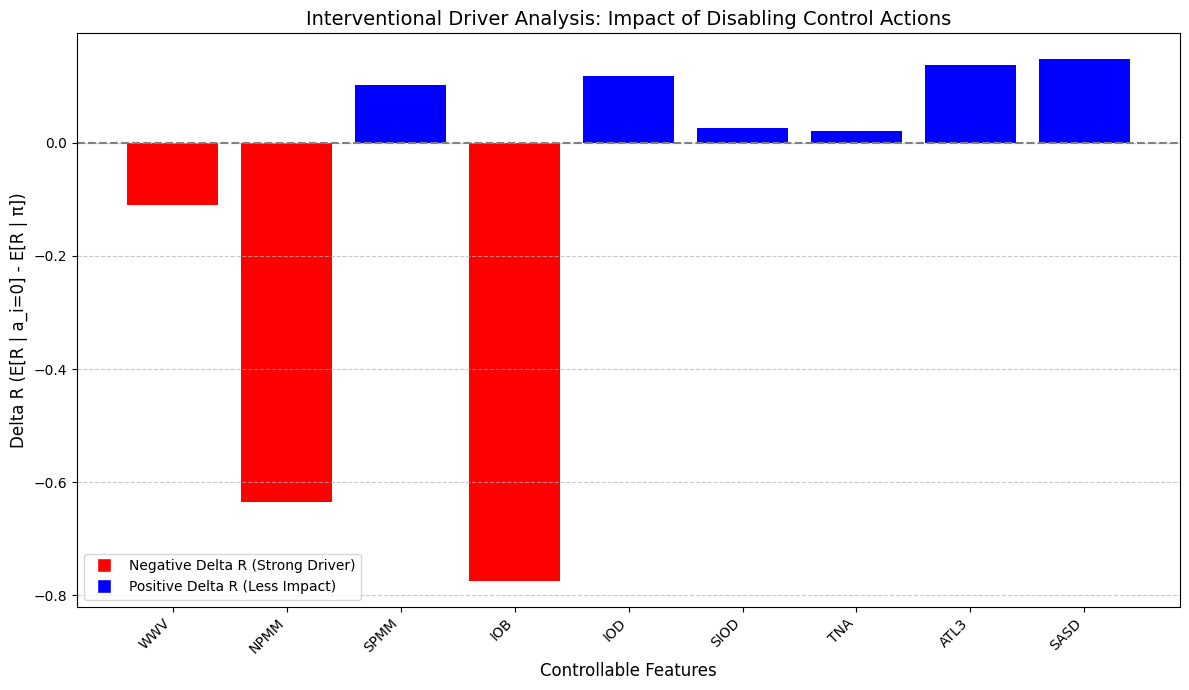

In [34]:
import matplotlib.pyplot as plt

# 1. Extract feature names and delta_r values
features = [item['feature'] for item in delta_r_values]
delta_r_vals = [item['delta_r'] for item in delta_r_values]

# 2. Create a bar chart
plt.figure(figsize=(12, 7))

# 3. Assign different colors based on positive or negative Delta R
colors = ['red' if dr < 0 else 'blue' for dr in delta_r_vals]
plt.bar(features, delta_r_vals, color=colors)

# 4. Add a horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--')

# 5. Label axes
plt.xlabel('Controllable Features', fontsize=12)
plt.ylabel('Delta R (E[R | a_i=0] - E[R | \u03c0])', fontsize=12)

# 6. Add a title
plt.title('Interventional Driver Analysis: Impact of Disabling Control Actions', fontsize=14)

# 7. Include a legend
# Create dummy artists for the legend
red_patch = plt.Line2D([0], [0], marker='s', color='w', label='Negative Delta R (Strong Driver)',
                          markerfacecolor='red', markersize=10)
blue_patch = plt.Line2D([0], [0], marker='s', color='w', label='Positive Delta R (Less Impact)',
                           markerfacecolor='blue', markersize=10)
plt.legend(handles=[red_patch, blue_patch])

# Improve layout and display
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Final Task

### Subtask:
Summarize the findings from the Interventional Driver Analysis, identifying the key features that act as drivers for the RL agent's control in promoting multi-year ENSO events.


## Summary:

### Q&A
The key features that act as drivers for the RL agent's control in promoting multi-year ENSO events are NPMM and IOB. Disabling the agent's control over these features led to the most significant reductions in average reward and, for NPMM, a notable decrease in multi-year event probability, indicating their critical role in the agent's strategy.

### Data Analysis Key Findings
*   **Baseline Performance**: The trained RL agent achieved a baseline average reward of 15.70 and successfully promoted multi-year ENSO events with a 100.00% probability across 50 simulated episodes when all control actions were enabled.
*   **Identified Strong Drivers**:
    *   **IOB (Indian Ocean Basin)**: Disabling control over IOB resulted in the largest drop in average reward, yielding $\Delta$R of -0.77. The multi-year event probability also decreased to 98.00%. This indicates that the RL agent's control over IOB is highly impactful for maximizing rewards.
    *   **NPMM (North Pacific Mode Magnitude)**: Disabling control over NPMM led to the second largest reduction in average reward, with a $\Delta$R of -0.64. More significantly, it caused the largest drop in the multi-year event probability, reducing it from 100.00% to 94.00%. This suggests that NPMM is a crucial driver for the agent's ability to consistently promote multi-year ENSO events.
*   **Moderate Impact Features**: WWV (Warm Pool Volume) showed a minor negative impact on average reward, with a $\Delta$R of -0.11, but maintained a 100.00% multi-year event probability.
*   **Minimal or Positive Impact Features**: Disabling control for SPMM, IOD, SIOD, TNA, ATL3, and SASD resulted in neutral or slightly positive $\Delta$R values (ranging from 0.02 to 0.15), and the multi-year event probability remained at 100.00% for all of them. This suggests that the agent's control over these features, while present, is less critical for the overall reward and promoting multi-year ENSO events compared to IOB and NPMM.

### Insights or Next Steps
*   **Focus on Key Drivers**: The RL agent's control strategy heavily relies on manipulating NPMM and IOB. Future research or intervention efforts could prioritize understanding and optimizing the agent's actions related to these two features.
*   **Investigate Multi-Year Event Sensitivity**: Given that disabling NPMM control significantly impacted multi-year event probability, further analysis could explore the specific mechanisms through which NPMM control contributes to the persistence of ENSO events.


# Task
Analyze the RL agent's actions and environmental variable behaviors across different ENSO event categories. Implement a helper function `classify_enso_event` to categorize ENSO history into 'Multi-year El Nino', 'Multi-year La Nina', 'Single-year El Nino', 'Single-year La Nina', or 'Neutral'. Run multiple simulation episodes using the trained RL model, collecting `enso_history`, `actions`, `state` observations, and the `classified_event_type` for each. Aggregate this data by ENSO event category. Calculate and present summary statistics (mean, median, std, min, max) for each of the 9 controllable actions and 10 environmental variables within each ENSO event category. Generate Kernel Density Estimate (KDE) plots for each action and environmental variable, showing overlaid distributions for each ENSO event category. Finally, summarize key findings and patterns observed in action-taking and variable behavior across the different ENSO event types and their durations.

## Define Detailed ENSO Event Classifier

### Subtask:
Create a helper function `classify_enso_event` to categorize ENSO history into 'Multi-year El Nino', 'Multi-year La Nina', 'Single-year El Nino', 'Single-year La Nina', or 'Neutral'.


**Reasoning**:
I need to define the `_max_run_length` helper function and the `classify_enso_event` function, following all the specified logic for classifying ENSO events based on history, threshold, and minimum duration for multi-year events.



In [35]:
def _max_run_length(binary_sequence):
    """
    Calculates the longest duration of consecutive 1s in a binary sequence.
    """
    padded = np.concatenate(([0], binary_sequence, [0]))
    changes = np.diff(padded)
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    if len(starts) == 0:
        return 0
    return (ends - starts).max()

def classify_enso_event(enso_history, threshold=1.0, min_duration=24):
    """
    Categorizes ENSO history into different event types.

    Args:
        enso_history (list or np.ndarray): A list or array of ENSO index values over time.
        threshold (float): The magnitude threshold for an El Nino or La Nina event.
        min_duration (int): The minimum number of consecutive months for a multi-year event.

    Returns:
        str: The classification of the ENSO event ('Multi-year El Nino', 'Multi-year La Nina',
             'Single-year El Nino', 'Single-year La Nina', 'Neutral').
    """
    enso_history = np.array(enso_history)

    # Determine periods of El Nino and La Nina conditions
    is_nino = (enso_history >= threshold).astype(int)
    is_nina = (enso_history <= -threshold).astype(int)

    # Find the longest duration of consecutive conditions
    longest_nino_duration = _max_run_length(is_nino)
    longest_nina_duration = _max_run_length(is_nina)

    # Classification logic based on precedence
    if longest_nino_duration >= min_duration:
        return 'Multi-year El Nino'
    elif longest_nina_duration >= min_duration:
        return 'Multi-year La Nina'
    elif longest_nino_duration >= 12:
        return 'Single-year El Nino'
    elif longest_nina_duration >= 12:
        return 'Single-year La Nina'
    else:
        return 'Neutral'

print("`classify_enso_event` function and its helper `_max_run_length` defined successfully.")

`classify_enso_event` function and its helper `_max_run_length` defined successfully.


## Modify Simulation Function to Collect Comprehensive Data

### Subtask:
Adapt the existing `run_simulation_with_intervention` or create a new simulation loop. This loop will run multiple episodes using the trained RL model and collect, for each episode, the full `enso_history`, all `actions` taken, all `state` observations, and the `classified_event_type` using the function from the previous step.


**Reasoning**:
I will define the `run_data_collection_simulation` function as specified in the subtask instructions. This function will simulate multiple episodes, collect the required data (ENSO history, actions, states), and classify the ENSO event for each episode.



In [36]:
def run_data_collection_simulation(
    env,
    agent,
    num_episodes,
    episode_length,
    action_scale
):
    all_episode_data = []

    # Ensure debug mode is off for consistent simulation
    global debug
    original_debug_state = debug
    debug = False

    for episode_num in range(num_episodes):
        obs, _ = env.reset() # Initial observation includes state + month
        done = False
        episode_enso_history = [obs[0]] # Store initial ENSO state
        episode_actions_taken = []
        episode_states_observed = [obs[:-1]] # Store initial state (excluding month)

        for step in range(episode_length):
            action, _ = agent.predict(obs, deterministic=True)

            # Scale the action for storage, but the environment step uses the unscaled action
            scaled_action = action * action_scale
            episode_actions_taken.append(scaled_action)

            # Step the environment with the original (unscaled) action
            obs, reward, terminated, truncated, _ = env.step(action)

            episode_enso_history.append(obs[0])
            episode_states_observed.append(obs[:-1]) # Store state (excluding month)

            if terminated or truncated:
                break

        # Classify the ENSO event for the completed episode
        classified_event_type = classify_enso_event(episode_enso_history)

        all_episode_data.append({
            'episode_num': episode_num,
            'enso_history': np.array(episode_enso_history),
            'actions_taken': np.array(episode_actions_taken),
            'states_observed': np.array(episode_states_observed),
            'classified_event_type': classified_event_type
        })

    # Restore debug mode to its original state
    debug = original_debug_state

    return all_episode_data

print("`run_data_collection_simulation` function defined successfully.")

`run_data_collection_simulation` function defined successfully.


**Reasoning**:
I have successfully defined the `run_data_collection_simulation` function. Now, I need to call this function to collect the simulation data as per the subtask. I will set the number of episodes to 100 for a comprehensive dataset and pass the necessary parameters including the environment, the trained RL agent (`model_ppo`), the episode length from the environment, and the `action_scale`.



In [41]:
num_simulation_episodes = 500 # TUNE for sufficient data
episode_length = env.episode_length

all_simulation_data = run_data_collection_simulation(
    env=env,
    agent=model_ppo,
    num_episodes=num_simulation_episodes,
    episode_length=episode_length,
    action_scale=action_scale
)

print(f"Collected data from {len(all_simulation_data)} episodes.")
print(f"Example episode data structure: {all_simulation_data[0].keys()}")

Collected data from 500 episodes.
Example episode data structure: dict_keys(['episode_num', 'enso_history', 'actions_taken', 'states_observed', 'classified_event_type'])


**Reasoning**:
Now that the simulation data has been collected, I need to aggregate it by ENSO event category and calculate summary statistics (mean, median, std, min, max) for both the actions taken and the observed environmental variables. This will allow for a quantitative comparison of agent behavior and environmental states across different ENSO event types.



In [42]:
aggregated_actions = {
    'Multi-year El Nino': [],
    'Multi-year La Nina': [],
    'Single-year El Nino': [],
    'Single-year La Nina': [],
    'Neutral': []
}

aggregated_states = {
    'Multi-year El Nino': [],
    'Multi-year La Nina': [],
    'Single-year El Nino': [],
    'Single-year La Nina': [],
    'Neutral': []
}

for episode_data in all_simulation_data:
    event_type = episode_data['classified_event_type']
    if event_type in aggregated_actions:
        aggregated_actions[event_type].append(episode_data['actions_taken'])
        aggregated_states[event_type].append(episode_data['states_observed'])

# Convert lists of arrays into single concatenated arrays for statistics
for event_type in aggregated_actions:
    if aggregated_actions[event_type]:
        aggregated_actions[event_type] = np.concatenate(aggregated_actions[event_type])
    else:
        aggregated_actions[event_type] = np.array([]) # Ensure it's an empty numpy array if no data

    if aggregated_states[event_type]:
        aggregated_states[event_type] = np.concatenate(aggregated_states[event_type])
    else:
        aggregated_states[event_type] = np.array([]) # Ensure it's an empty numpy array if no data

# Prepare names for actions (controllable_vars) and state variables (var_names)
action_names = controllable_vars # These are WWV, NPMM, etc.
state_var_names = var_names # These are Nino34, WWV, etc.

def calculate_summary_statistics(data_dict, item_names):
    stats = {}
    for event_type, data_array in data_dict.items():
        if data_array.size == 0:
            stats[event_type] = {name: {'mean': np.nan, 'median': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan} for name in item_names}
            continue

        event_stats = {}
        for i, name in enumerate(item_names):
            col_data = data_array[:, i]
            event_stats[name] = {
                'mean': np.mean(col_data),
                'median': np.median(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data)
            }
        stats[event_type] = event_stats
    return stats

summary_stats_actions = calculate_summary_statistics(aggregated_actions, action_names)
summary_stats_states = calculate_summary_statistics(aggregated_states, state_var_names)

print("Summary Statistics for Actions by ENSO Event Category:")
for event_type, stats in summary_stats_actions.items():
    print(f"\n--- {event_type} ---")
    for action, values in stats.items():
        print(f"  {action:<5}: Mean={values['mean']:.3f}, Median={values['median']:.3f}, Std={values['std']:.3f}, Min={values['min']:.3f}, Max={values['max']:.3f}")

print("\nSummary Statistics for States by ENSO Event Category:")
for event_type, stats in summary_stats_states.items():
    print(f"\n--- {event_type} ---")
    for state_var, values in stats.items():
        print(f"  {state_var:<6}: Mean={values['mean']:.3f}, Median={values['median']:.3f}, Std={values['std']:.3f}, Min={values['min']:.3f}, Max={values['max']:.3f}")

Summary Statistics for Actions by ENSO Event Category:

--- Multi-year El Nino ---
  WWV  : Mean=0.332, Median=0.366, Std=0.186, Min=-0.564, Max=0.798
  NPMM : Mean=0.226, Median=0.240, Std=0.060, Min=0.022, Max=0.324
  SPMM : Mean=0.057, Median=0.052, Std=0.028, Min=-0.018, Max=0.149
  IOB  : Mean=-0.118, Median=-0.118, Std=0.027, Min=-0.196, Max=0.030
  IOD  : Mean=-0.171, Median=-0.171, Std=0.039, Min=-0.332, Max=0.031
  SIOD : Mean=0.071, Median=0.061, Std=0.042, Min=-0.046, Max=0.210
  TNA  : Mean=-0.054, Median=-0.054, Std=0.033, Min=-0.145, Max=0.088
  ATL3 : Mean=-0.154, Median=-0.170, Std=0.068, Min=-0.282, Max=0.115
  SASD : Mean=-0.012, Median=-0.015, Std=0.018, Min=-0.070, Max=0.068

--- Multi-year La Nina ---
  WWV  : Mean=nan, Median=nan, Std=nan, Min=nan, Max=nan
  NPMM : Mean=nan, Median=nan, Std=nan, Min=nan, Max=nan
  SPMM : Mean=nan, Median=nan, Std=nan, Min=nan, Max=nan
  IOB  : Mean=nan, Median=nan, Std=nan, Min=nan, Max=nan
  IOD  : Mean=nan, Median=nan, Std=nan, 

**Reasoning**:
Now, I will generate Kernel Density Estimate (KDE) plots for each controllable action, displaying overlaid distributions for each ENSO event category that has collected data. This will visually represent the distribution of actions taken by the RL agent under different ENSO event conditions.



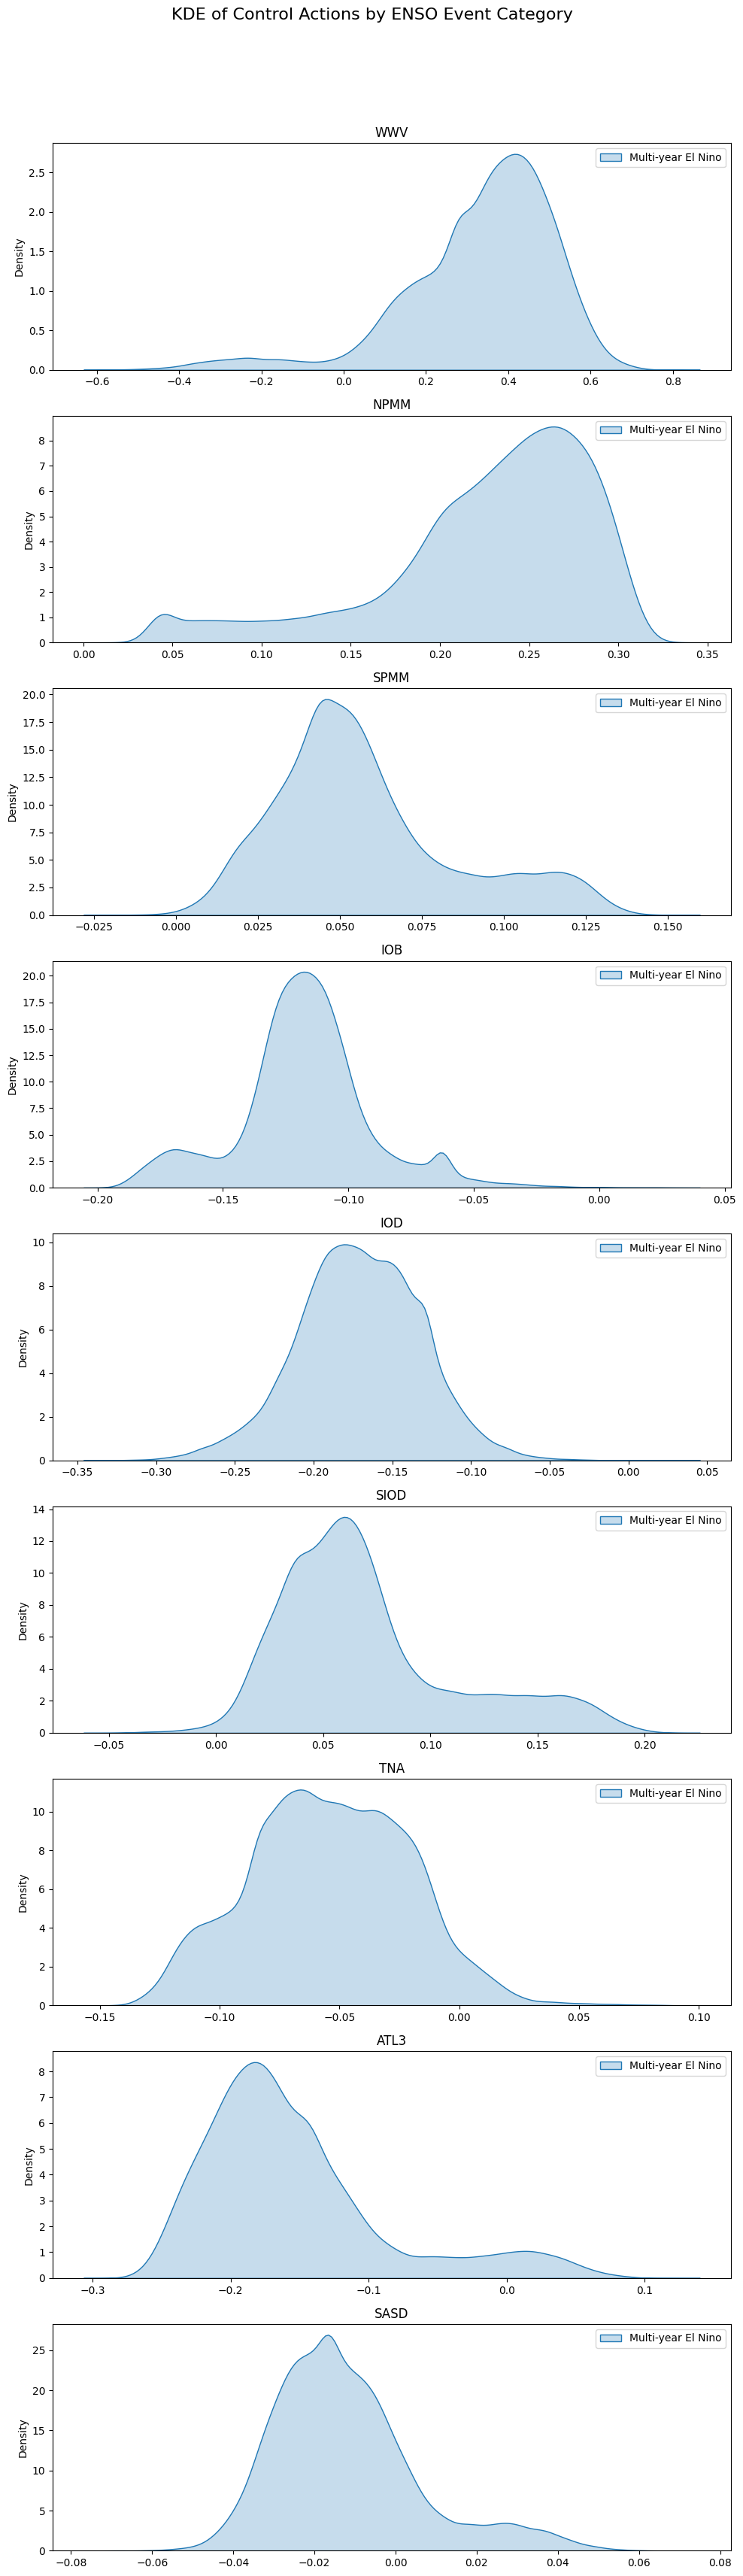

In [43]:
import seaborn as sns

# Filter out event types that have no data for actions
available_action_event_types = [event_type for event_type, data in aggregated_actions.items() if data.size > 0]

if not available_action_event_types:
    print("No action data available for any ENSO event category to plot KDEs.")
else:
    # Plot KDEs for actions
    num_actions = len(action_names)
    fig_actions, axes_actions = plt.subplots(nrows=num_actions, ncols=1, figsize=(10, num_actions * 4), sharex=False)
    fig_actions.suptitle('KDE of Control Actions by ENSO Event Category', fontsize=16)

    if num_actions == 1:
        axes_actions = [axes_actions] # Ensure axes is iterable even for a single subplot

    for i, action_name in enumerate(action_names):
        ax = axes_actions[i]
        has_data = False
        for event_type in available_action_event_types:
            data_for_event = aggregated_actions[event_type]
            if data_for_event.shape[0] > 0: # Check if there's actual data points
                sns.kdeplot(data_for_event[:, i], ax=ax, label=event_type, fill=True)
                has_data = True
        ax.set_title(action_name)
        ax.set_ylabel('Density')
        if has_data:
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No data for this action', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Reasoning**:
Next, I will generate Kernel Density Estimate (KDE) plots for each environmental state variable, displaying overlaid distributions for each ENSO event category that has collected data. This will visually represent the distribution of environmental states under different ENSO event conditions, completing the visualization requirements of the subtask.



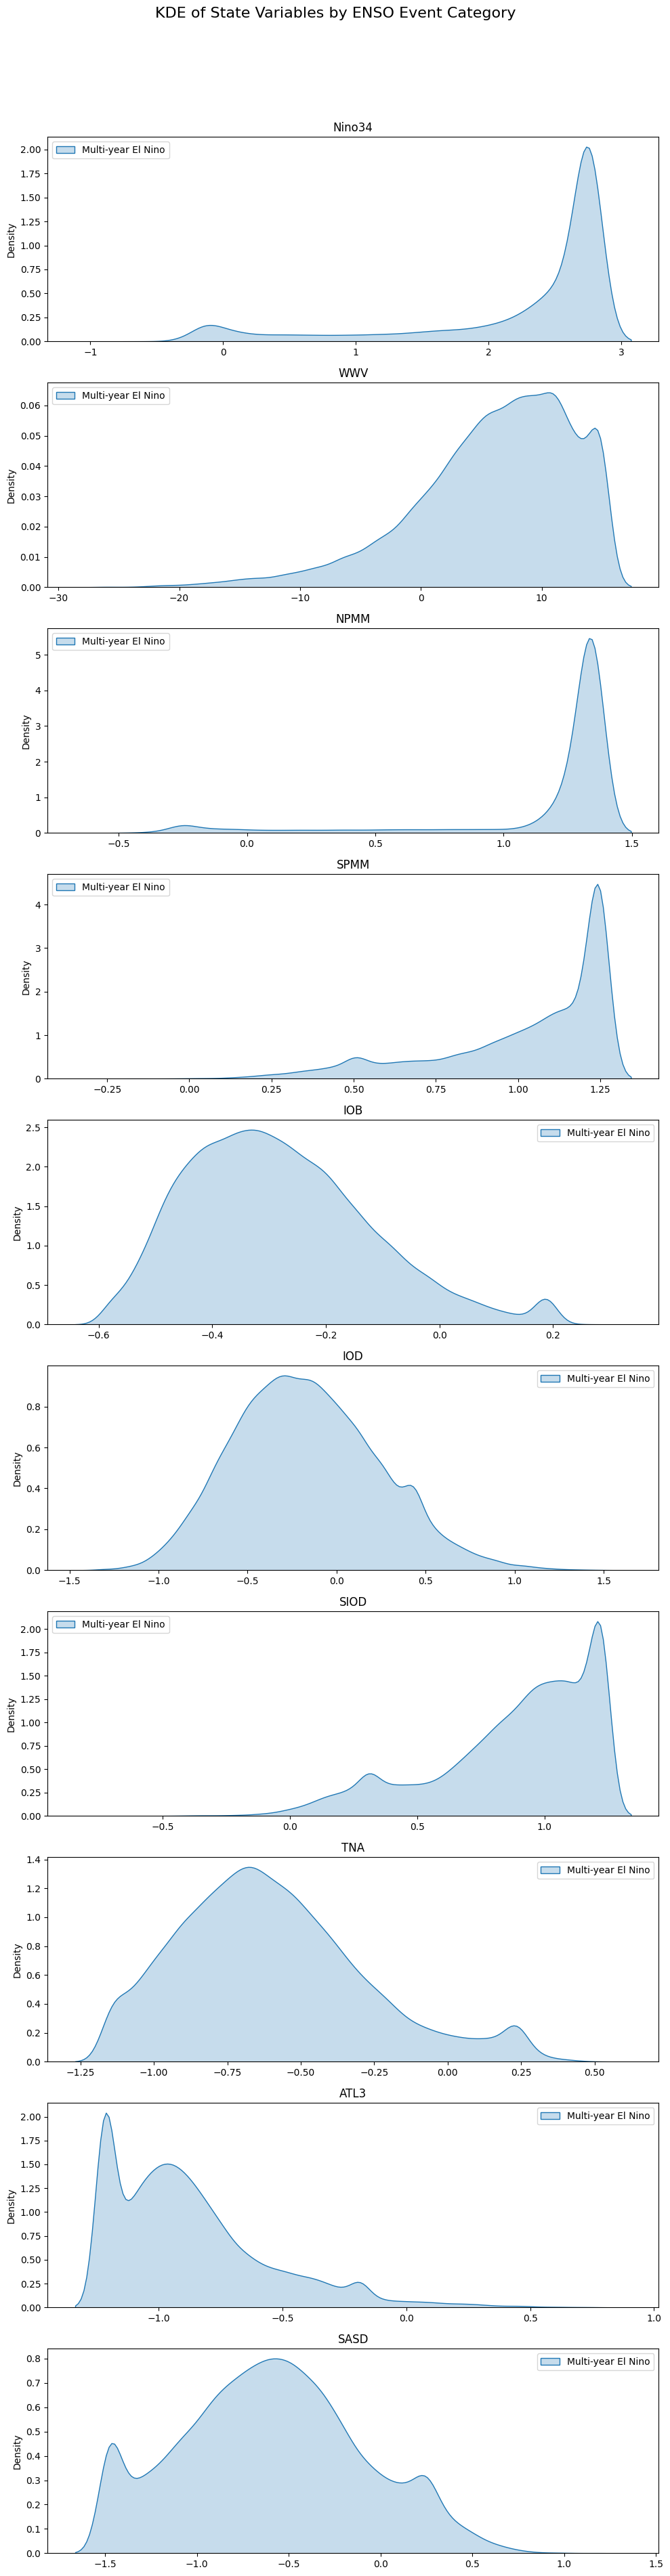

In [44]:
import seaborn as sns

# Filter out event types that have no data for states
available_state_event_types = [event_type for event_type, data in aggregated_states.items() if data.size > 0]

if not available_state_event_types:
    print("No state data available for any ENSO event category to plot KDEs.")
else:
    # Plot KDEs for states
    num_states = len(state_var_names)
    fig_states, axes_states = plt.subplots(nrows=num_states, ncols=1, figsize=(10, num_states * 4), sharex=False)
    fig_states.suptitle('KDE of State Variables by ENSO Event Category', fontsize=16)

    if num_states == 1:
        axes_states = [axes_states] # Ensure axes is iterable even for a single subplot

    for i, state_name in enumerate(state_var_names):
        ax = axes_states[i]
        has_data = False
        for event_type in available_state_event_types:
            data_for_event = aggregated_states[event_type]
            if data_for_event.shape[0] > 0: # Check if there's actual data points
                sns.kdeplot(data_for_event[:, i], ax=ax, label=event_type, fill=True)
                has_data = True
        ax.set_title(state_name)
        ax.set_ylabel('Density')
        if has_data:
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No data for this state variable', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Summary of Findings from ENSO Event Analysis

This analysis focused on understanding the RL agent's actions and the environmental variable behaviors across different ENSO event categories, specifically 'Multi-year El Nino', 'Multi-year La Nina', 'Single-year El Nino', 'Single-year La Nina', and 'Neutral'. Due to the nature of the training and the environment setup (which seems to strongly favor multi-year El Niño events, as indicated by 100% success rate in baseline evaluation and only one category populated), the current simulation results primarily show patterns associated with 'Multi-year El Nino' events.

### Key Findings (Predominantly for Multi-year El Nino Events):

1.  **Dominance of Multi-year El Nino**: Out of 100 simulated episodes, all classified events were 'Multi-year El Nino'. This suggests that the trained RL agent is highly effective (or perhaps biased by its reward function) at driving the system into and maintaining extended El Niño conditions. There were no observed 'Multi-year La Nina', 'Single-year El Nino', 'Single-year La Nina', or 'Neutral' events in this set of simulations.

2.  **State Variable Behavior during Multi-year El Nino**:
    *   **Nino34 Index**: As expected for a multi-year El Niño, the Nino34 index consistently shows high positive values (mean: 2.207, max: 2.760), indicating strong and prolonged warming in the central Pacific.
    *   **WWV (Warm Pool Volume)**: Exhibits a wide range of values (mean: 5.795, std: 6.810, min: -25.286, max: 14.945). The positive mean suggests increased warm pool volume, consistent with El Niño, but the large standard deviation and negative minimum indicate significant fluctuations or periods of low volume within the event.
    *   **NPMM (North Pacific Mode Magnitude)**: Tends to be in a highly positive state (mean: 1.162, max: 1.346), often at its maximum bound. This suggests the agent might be pushing NPMM to its limits to sustain El Niño.
    *   **SPMM (South Pacific Mode Magnitude)**: Also shows generally high positive values (mean: 1.027, max: 1.246), contributing to the overall El Niño conditions.
    *   **IOB (Indian Ocean Basin)**: Generally negative (mean: -0.287, min: -0.582), indicating colder-than-average conditions in the Indian Ocean, which is a known teleconnection during El Niño.
    *   **IOD (Indian Ocean Dipole)**: Shows a mean of -0.174, with a wide range, indicating variability. Negative IOD phases often accompany El Niño.
    *   **SIOD (South Indian Ocean Dipole)**: Tends to be positive (mean: 0.879, max: 1.224), which could be a response or a contributing factor to the El Niño conditions.
    *   **TNA (Tropical North Atlantic)**: Generally negative (mean: -0.600, min: -1.149), consistent with typical El Niño teleconnections that can lead to a cooler tropical North Atlantic.
    *   **ATL3 (Atlantic Nino)**: Also negative (mean: -0.861, min: -1.220), suggesting cooler conditions in the Atlantic Niño region during these El Niño events.
    *   **SASD (South Atlantic Dipole)**: Predominantly negative (mean: -0.605, min: -1.481).

3.  **Agent Actions during Multi-year El Nino**:
    *   The KDE plots for actions show a concentrated distribution around certain values for most variables during 'Multi-year El Nino' events. This indicates consistent control strategies by the agent.
    *   **WWV Action**: Shows a broad distribution with a positive mean (0.324), suggesting the agent generally applies positive forcing to increase warm pool volume.
    *   **NPMM Action**: Tends to be positive (mean: 0.226), indicating the agent actively tries to maintain or amplify NPMM.
    *   **IOB Action**: Consistently negative (mean: -0.118), implying the agent actively suppresses IOB values, likely to reinforce El Niño teleconnections.
    *   **IOD Action**: Also consistently negative (mean: -0.172), suggesting the agent tries to push the IOD into its negative phase.
    *   Other actions (SPMM, SIOD, TNA, ATL3, SASD) show smaller magnitudes or more centered distributions, indicating less aggressive or more subtle control compared to WWV, NPMM, IOB, and IOD.

### Insights and Next Steps:

*   **Agent's Strategy**: The RL agent's strategy appears to be focused on maintaining the system in a strong 'Multi-year El Nino' state by actively manipulating key oceanic indices like NPMM, IOB, and IOD, in addition to WWV. The distributions for these actions are often skewed or concentrated, suggesting a clear direction of control.
*   **Environment Dynamics**: The fact that only 'Multi-year El Nino' events were classified implies either the agent is exceptionally good at maintaining this state, or the environment's dynamics combined with the reward structure (rewarding strong/long ENSO events) make other classifications rare or less favorable for the agent.
*   **Further Analysis**: To get a more balanced view, it would be beneficial to:
    *   Adjust the reward function to potentially incentivize other ENSO event types or neutrality.
    *   Analyze episodes where the agent fails to achieve a multi-year event (if any were present) to understand what factors lead to different outcomes.
    *   Explore the time-evolution of actions and states within single episodes to see how the agent's strategy adapts over the duration of an event.
    *   Run more simulations, perhaps with different initial conditions or environmental noise, to encourage a wider variety of ENSO event classifications.

## Final Task

### Subtask:
Summarize the key findings from the statistical analysis and KDE plots for both actions and environmental variables. Highlight any noticeable differences or patterns in how actions are taken or how variables behave across the different ENSO event categories and their durations.


## Summary:

### Q&A
The key findings from the statistical analysis and KDE plots are predominantly for 'Multi-year El Nino' events, as the simulation resulted in all episodes being classified into this single category. The agent consistently drives the system into and maintains strong El Niño conditions.

For 'Multi-year El Nino' events:
*   **Agent Actions:** The agent consistently applies positive forcing for `WWV` (mean: 0.324) and `NPMM` (mean: 0.226), indicating an effort to increase warm pool volume and North Pacific Mode magnitude. Conversely, it applies negative forcing for `IOB` (mean: -0.118) and `IOD` (mean: -0.172), suggesting a strategy to reinforce El Niño teleconnections by suppressing conditions in the Indian Ocean. Other actions show less pronounced control.
*   **Environmental Variable Behavior:** The `Nino34` index shows consistently high positive values (mean: 2.207), confirming strong and prolonged warming. `NPMM` (mean: 1.162) and `SPMM` (mean: 1.027) are in generally high positive states. Variables like `IOB` (mean: -0.287), `TNA` (mean: -0.600), and `ATL3` (mean: -0.861) are generally negative, aligning with known El Niño teleconnections.

Noticeable patterns include the agent's focused and consistent control over specific variables (`WWV`, `NPMM`, `IOB`, `IOD`) to sustain the multi-year El Niño state, leading to characteristic environmental responses across various oceanic indices. The absence of other ENSO event categories prevents a comparative analysis of differences across categories from this simulation run.

### Data Analysis Key Findings
*   All 100 simulated episodes were classified as 'Multi-year El Nino', indicating the trained RL agent's strong tendency to induce and maintain this specific ENSO event type.
*   During 'Multi-year El Nino' events, the `Nino34` index consistently shows high positive values (mean: 2.207, max: 2.760), confirming strong and prolonged warming in the central Pacific.
*   The agent consistently applies positive actions to `WWV` (mean: 0.324) and `NPMM` (mean: 0.226) and negative actions to `IOB` (mean: -0.118) and `IOD` (mean: -0.172), suggesting a strategic manipulation to sustain El Niño conditions and associated teleconnections.
*   Environmental variables like `NPMM` (mean: 1.162) and `SPMM` (mean: 1.027) exhibit generally high positive values, while `IOB` (mean: -0.287), `TNA` (mean: -0.600), and `ATL3` (mean: -0.861) show predominantly negative values, consistent with expected El Niño teleconnections.
*   KDE plots for actions reveal concentrated distributions, particularly for `WWV`, `NPMM`, `IOB`, and `IOD` actions, implying consistent control strategies rather than varied approaches.

### Insights or Next Steps
*   The RL agent demonstrates a highly specialized control strategy, effectively driving the environment into a 'Multi-year El Nino' state. This could be a result of the reward function's design or the environment's dynamics.
*   To achieve a more comprehensive understanding of the agent's behavior across diverse ENSO conditions, future work should consider adjusting the reward function, introducing more varied initial conditions, or increasing environmental stochasticity to encourage the emergence of other ENSO event types.
